In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import torchvision


torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [0]:
class Net(nn.Module): 

  torch.manual_seed(100)
  def __init__(self, image_dim, image_channel):
    super(Net, self).__init__()
    self.image_dim = image_dim    
    self.image_channel = image_channel
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride = 2, padding = 0)
    self.conv3 = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=5)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride = 2)
    
    self.fc1 = nn.Linear(in_features=15*15*2, out_features=120)
    self.drop_out = nn.Dropout(0.5)
    self.fc2 = nn.Linear(in_features=120, out_features=40)
    self.fc3 = nn.Linear(in_features= 40, out_features=2)
        

  def forward(self, x):
      x = self.conv1(x)
      x = torch.relu(x)
      x = self.pool1(x)


      x = self.conv2(x)
      x = torch.relu(x)
      x = self.pool2(x)
      

      x = self.conv3(x)
      x = torch.relu(x)
      x = self.pool3(x)
      

      x = x.view(-1, 15*15*2)


      x = self.fc1(x)   
      x = torch.relu(x) # ReLu(fc1)


      x = self.drop_out(x)
      x = self.fc2(x)
      x = torch.relu(x)

      x = self.fc3(x)
      x = torch.sigmoid(x) # sigmoid(fc2)

      return x

In [3]:
def predict(pred_proba, actual_labels):
  actual_labels = actual_labels.cpu().numpy()
  pred_proba = pred_proba.cpu().numpy()

  length = pred_proba.shape[0]
  prediction = np.zeros(length)
  
  for i in range(length):
    if pred_proba[i][1] > 0.5:
      prediction[i] = 1

  return np.sum((prediction == actual_labels)/length)


def run_module(model, optim, loss_function, epochs, learning_rate, train_x, train_y, test_x, test_y, print_value):

  t0 = time.time()

  train_epoch_loss = []
  test_epoch_loss = []
  test_accuracy = []
  train_accuracy = []

  for epoch in range(epochs): 

    # training phase
    model.train()
    
    train_loss = []

    model_output = model.forward(train_x.float())
    loss = loss_function(model_output, train_y) 
    train_loss.append(loss.item())
    train_epoch_loss.append(np.mean(train_loss))
    
    optim.zero_grad()  
    loss.backward()  
    optim.step()  
  
    # validation phase
    model.eval()  
    val_loss = []

    with torch.no_grad():   
      model_output = model(test_x.float())
      loss = loss_function(model_output, test_y)
      val_loss.append(loss.item())
      test_epoch_loss.append(np.mean(val_loss))
      test_accuracy.append(predict(model_output, test_y))
      train_accuracy.append(predict(model(train_x.float()), train_y))


    if print_value == True and epoch%50 == 0:
      print("Epoch : {}, Train loss: {} , Val loss: {}".format(epoch, np.mean(train_loss), np.mean(val_loss)))
      print("accuarcy", predict(model_output, test_y))
      
      
      

  print("Total time taken: {} seconds".format(time.time()- t0))

  return model, train_epoch_loss, test_epoch_loss, train_accuracy, test_accuracy, model_output, test_y


# FUNCTION TO LOAD THE IMAGE TEST AND TRAIN DATA


import pickle
from collections import Counter


def load_data(file_train_images, file_train_labels, file_test_images, file_test_labels):
  pickle_in = open("drive/My Drive/project_cmsc498l/"+file_train_images, "rb")
  train_set_x_orig = pickle.load(pickle_in)
  pickle_in.close()

  pickle_in = open("drive/My Drive/project_cmsc498l/"+file_train_labels, "rb")
  train_set_y_orig = pickle.load(pickle_in)
  pickle_in.close()

  pickle_in = open("drive/My Drive/project_cmsc498l/"+file_test_images, "rb")
  test_set_x_orig = pickle.load(pickle_in)
  pickle_in.close()

  pickle_in = open("drive/My Drive/project_cmsc498l/"+file_test_labels, "rb")
  test_set_y_orig = pickle.load(pickle_in)
  pickle_in.close()



  classes = np.array([0,1])

  train_set_x_orig = np.asarray(train_set_x_orig)
  test_set_x_orig = np.asarray(test_set_x_orig)
  train_set_y_orig = np.asarray(train_set_y_orig)
  test_set_y_orig = np.asarray(test_set_y_orig)

  print("train dataset class distribution ", Counter(train_set_y_orig))
  print("test dataset class distribution ", Counter(test_set_y_orig))
  print("----")

  train_set_y_orig = train_set_y_orig.reshape(train_set_y_orig.shape[0], 1)
  test_set_y_orig = test_set_y_orig.reshape(test_set_y_orig.shape[0], 1)


  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



file_train_images = "train_images_152x152.pickle"
file_train_labels = "train_labels_152x152.pickle"

file_test_images = "test_images_152x152.pickle"
file_test_labels = "test_labels_152x152.pickle"

train_x_orig, train_y, test_x_orig, test_y, classes = load_data(file_train_images, file_train_labels, file_test_images, file_test_labels)



print("train data-set shape", train_x_orig.shape)
print("test data-set shape", test_x_orig.shape)
print("----")
print("train label shape", train_y.shape)
print("test label shape", test_y.shape)
print("----")

# standardizing data to have values between 0 and 1
train_x = train_x_orig
test_x = test_x_orig

# changing the shape of train_y and test_y
train_y = train_y.reshape(train_y.shape[0])
test_y = test_y.reshape(test_y.shape[0])

true_y = test_y
# converting numpy arrays to torch tensors
train_x = torch.from_numpy(train_x)
test_x = torch.from_numpy(test_x)
train_y = torch.from_numpy(train_y)
test_y = torch.from_numpy(test_y)

print("shape train_x", train_x.shape)
print("shape test_x", test_x.shape)
print("shape train_y", train_y.shape)
print("shape test_y", test_y.shape)

print("----")

train_x = train_x.view(2980,152,152,1)
test_x = test_x.view(150,152,152,1)

train_x = train_x.view(- 1, 1, 152, 152)
test_x = test_x.view(-1, 1, 152, 152)

print("shape train_x", train_x.shape)
print("shape test_x", test_x.shape)
print("shape train_y", train_y.shape)
print("shape test_y", test_y.shape)

train dataset class distribution  Counter({0: 1595, 1: 1385})
test dataset class distribution  Counter({0: 78, 1: 72})
----
train data-set shape (2980, 152, 152)
test data-set shape (150, 152, 152)
----
train label shape (2980, 1)
test label shape (150, 1)
----
shape train_x torch.Size([2980, 152, 152])
shape test_x torch.Size([150, 152, 152])
shape train_y torch.Size([2980])
shape test_y torch.Size([150])
----
shape train_x torch.Size([2980, 1, 152, 152])
shape test_x torch.Size([150, 1, 152, 152])
shape train_y torch.Size([2980])
shape test_y torch.Size([150])


Epoch : 0, Train loss: 0.6922970414161682 , Val loss: 0.6926789283752441
accuarcy 0.52
Epoch : 50, Train loss: 0.6882433295249939 , Val loss: 0.6897545456886292
accuarcy 0.54
Epoch : 100, Train loss: 0.6762830018997192 , Val loss: 0.6809007525444031
accuarcy 0.5999999999999999
Epoch : 150, Train loss: 0.6169160008430481 , Val loss: 0.6252570748329163
accuarcy 0.6933333333333332
Epoch : 200, Train loss: 0.5649707317352295 , Val loss: 0.604921281337738
accuarcy 0.6933333333333334
Epoch : 250, Train loss: 0.5731405019760132 , Val loss: 0.5891277194023132
accuarcy 0.6933333333333334
Epoch : 300, Train loss: 0.5115103721618652 , Val loss: 0.5728744268417358
accuarcy 0.7333333333333333
Epoch : 350, Train loss: 0.464508593082428 , Val loss: 0.5733963847160339
accuarcy 0.7333333333333333
Epoch : 400, Train loss: 0.4289301037788391 , Val loss: 0.5548813343048096
accuarcy 0.7466666666666666
Epoch : 450, Train loss: 0.4185344874858856 , Val loss: 0.5756723284721375
accuarcy 0.7066666666666666
Epo

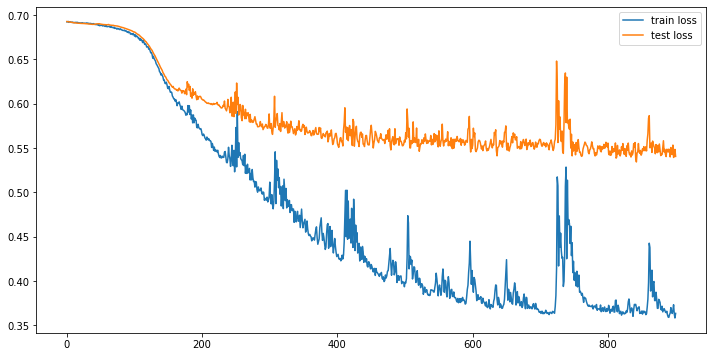

In [4]:
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

epochs = 901
learning_rate = 0.005
model_conv1 = Net(image_dim = 152, image_channel=1)  
model_conv1 = model_conv1.cuda()

train_x, train_y = train_x.cuda(), train_y.cuda()
test_x , test_y = test_x.cuda(), test_y.cuda()

optim = torch.optim.SGD(model_conv1.parameters(), lr = 0.005, momentum=0.9, weight_decay=0.1)  
loss_function = nn.CrossEntropyLoss()
model_conv1, train_epoch_loss, test_epoch_loss, train_accuracy, test_accuracy, pred_y, test_y = run_module(model_conv1, optim, loss_function, epochs, learning_rate, train_x, train_y, test_x, test_y, True)


epoch_array = [i for i in range(901)]
plt.figure(figsize = (12,6))
plt.plot(epoch_array, train_epoch_loss, label= "train loss")
plt.plot(epoch_array, test_epoch_loss, label = "test loss")
plt.legend()

In [0]:
y_pred = []
prob = []
for i in range(len(pred_y)):
  prob.append(pred_y[i][1])
  if pred_y[i][0] > 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

In [0]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, f1_score, roc_auc_score

print(confusion_matrix(true_y, y_pred))
print(precision_score(true_y, y_pred))
print(recall_score(true_y, y_pred))


[[67 11]
 [22 50]]
0.819672131147541
0.6944444444444444


In [0]:
print(f1_score(true_y, y_pred))

0.7518796992481204


In [0]:
true_y = list(true_y)

Text(0, 0.5, 'true positive rate')

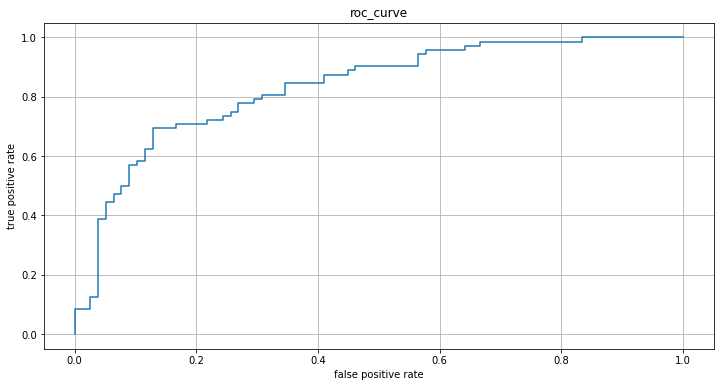

In [0]:
fpr, tpr, thresholds = roc_curve(true_y, prob, pos_label=1)
plt.figure(figsize = (12,6))
plt.plot(fpr, tpr)
plt.title("roc_curve")
plt.grid()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [0]:
print(roc_auc_score(true_y, prob))

0.8327991452991453
